# Moving Average Crossover Strategy

Classic technical analysis strategy:
- **Buy Signal:** Fast MA crosses above slow MA (golden cross)
- **Sell Signal:** Fast MA crosses below slow MA (death cross)
- Uses 50-day and 200-day moving averages

## Setup

In [1]:
# Register Sharadar bundle (required for Jupyter notebooks)
from zipline.data.bundles import register
from zipline.data.bundles.sharadar_bundle import sharadar_bundle

register('sharadar', sharadar_bundle(tickers=None, incremental=True, include_funds=True))
print("✓ Sharadar bundle registered")

✓ Sharadar bundle registered


In [2]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import (
    order_target_percent,
    symbol,
    record,
    get_open_orders,
)
from zipline.utils.progress import enable_progress_logging
from zipline.utils.flightlog_client import enable_flightlog

# Enable logging
logging.basicConfig(level=logging.INFO, force=True)

# Connect to FlightLog (optional)
# enable_flightlog(host='flightlog', port=9020)

# Enable progress tracking
enable_progress_logging(algo_name='MA-Crossover', update_interval=10)

## Strategy Configuration

In [3]:
# Strategy parameters
FAST_MA = 50   # Fast moving average period
SLOW_MA = 200  # Slow moving average period
STOCK = 'SPY'  # Stock to trade

## Strategy Implementation

In [4]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.stock = symbol(STOCK)
    
    # Track moving averages
    context.fast_ma = FAST_MA
    context.slow_ma = SLOW_MA
    
    # Need price history for MAs
    context.price_history = []
    
    # Track position
    context.invested = False
    
    # Trade counters
    context.buy_count = 0
    context.sell_count = 0
    
    logging.info(f"Strategy initialized")
    logging.info(f"  Stock: {STOCK}")
    logging.info(f"  Fast MA: {FAST_MA} days")
    logging.info(f"  Slow MA: {SLOW_MA} days")


def handle_data(context, data):
    """
    Called every trading day.
    """
    # Only proceed if stock is tradeable
    if not data.can_trade(context.stock):
        return
    
    # Get current price
    price = data.current(context.stock, 'price')
    
    # Get price history for moving averages
    hist = data.history(
        context.stock,
        'close',
        context.slow_ma + 1,  # Need enough data for slow MA
        '1d'
    )
    
    # Calculate moving averages
    fast_mavg = hist[-context.fast_ma:].mean()
    slow_mavg = hist[-context.slow_ma:].mean()
    
    # Previous day MAs (for crossover detection)
    prev_fast_mavg = hist[-(context.fast_ma+1):-1].mean()
    prev_slow_mavg = hist[-(context.slow_ma+1):-1].mean()
    
    # Detect crossovers
    golden_cross = (prev_fast_mavg <= prev_slow_mavg) and (fast_mavg > slow_mavg)
    death_cross = (prev_fast_mavg >= prev_slow_mavg) and (fast_mavg < slow_mavg)
    
    # Check for open orders (don't trade if already have pending order)
    open_orders = get_open_orders()
    
    # Trading logic
    if golden_cross and not context.invested and not open_orders:
        # BUY signal - fast MA crossed above slow MA
        order_target_percent(context.stock, 1.0)
        context.invested = True
        context.buy_count += 1
        logging.info(f"BUY {STOCK} at ${price:.2f} (Fast MA: ${fast_mavg:.2f}, Slow MA: ${slow_mavg:.2f})")
    
    elif death_cross and context.invested and not open_orders:
        # SELL signal - fast MA crossed below slow MA
        order_target_percent(context.stock, 0.0)
        context.invested = False
        context.sell_count += 1
        logging.info(f"SELL {STOCK} at ${price:.2f} (Fast MA: ${fast_mavg:.2f}, Slow MA: ${slow_mavg:.2f})")
    
    # Record values for analysis
    record(
        price=price,
        fast_ma=fast_mavg,
        slow_ma=slow_mavg,
        invested=1 if context.invested else 0,
        portfolio_value=context.portfolio.portfolio_value
    )


def analyze(context, perf):
    """
    Called after the backtest completes.
    """
    logging.info("\n" + "="*60)
    logging.info("BACKTEST RESULTS")
    logging.info("="*60)
    
    # Calculate returns
    start_value = perf['portfolio_value'].iloc[0]
    end_value = perf['portfolio_value'].iloc[-1]
    total_return = (end_value - start_value) / start_value * 100
    
    logging.info(f"Start date: {perf.index[0].date()}")
    logging.info(f"End date: {perf.index[-1].date()}")
    logging.info(f"")
    logging.info(f"Starting portfolio value: ${start_value:,.2f}")
    logging.info(f"Ending portfolio value: ${end_value:,.2f}")
    logging.info(f"Total return: {total_return:.2f}%")
    logging.info(f"")
    logging.info(f"Number of buys: {context.buy_count}")
    logging.info(f"Number of sells: {context.sell_count}")
    logging.info(f"Total trades: {context.buy_count + context.sell_count}")
    logging.info("="*60)

## Run Backtest

In [5]:
# Run the backtest
results = run_algorithm(
    start=pd.Timestamp('2018-01-01'),
    end=pd.Timestamp('2023-12-31'),
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,
    data_frequency='daily',
    bundle='sharadar',
)

⚠ Yahoo Finance bundles not available: No module named 'zipline.data.bundles.yahoo_bundle'
⚠ NASDAQ Data Link bundles not available: No module named 'zipline.data.bundles.nasdaq_bundle'
✓ Sharadar bundles registered

Available bundles:
  - yahoo, yahoo-tech, yahoo-dow, yahoo-sp500
  - nasdaq, nasdaq-premium, nasdaq-free, nasdaq-sp500
  - sharadar, sharadar-tech, sharadar-sp500, sharadar-all

Use 'zipline bundles' to see which bundles have been ingested.


/root/.zipline/extension.py:56: UserWarning: Overwriting bundle with name 'sharadar'
  register('sharadar', sharadar_bundle())


2025-11-18 07:38:45,036 INFO zipline.progress: [MA-Crossover] Backtest initialized: 2018-01-02 to 2023-12-29 (1509 trading days)
2025-11-18 07:38:45,037 INFO zipline.progress: [MA-Crossover] Progress      Pct    Date             Cum Returns        Sharpe      Max DD             Cum PNL


INFO:root:Strategy initialized
INFO:root:  Stock: SPY
INFO:root:  Fast MA: 50 days
INFO:root:  Slow MA: 200 days


2025-11-18 07:38:45,523 INFO zipline.progress: [MA-Crossover] ----------      0%  2018-01-16              0%          0.00          0%                  $0
2025-11-18 07:38:45,529 INFO zipline.progress: [MA-Crossover] ----------      1%  2018-01-30              0%          0.00          0%                  $0
2025-11-18 07:38:45,534 INFO zipline.progress: [MA-Crossover] ----------      1%  2018-02-13              0%          0.00          0%                  $0
2025-11-18 07:38:45,541 INFO zipline.progress: [MA-Crossover] ----------      2%  2018-02-28              0%          0.00          0%                  $0
2025-11-18 07:38:45,549 INFO zipline.progress: [MA-Crossover] ----------      3%  2018-03-14              0%          0.00          0%                  $0
2025-11-18 07:38:45,555 INFO zipline.progress: [MA-Crossover] ----------      3%  2018-03-28              0%          0.00          0%                  $0
2025-11-18 07:38:45,562 INFO zipline.progress: [MA-Crossover] --------

INFO:root:BUY SPY at $254.53 (Fast MA: $247.10, Slow MA: $246.75)


2025-11-18 07:38:45,735 INFO zipline.progress: [MA-Crossover] ██--------     20%  2019-03-27             -0%         -0.90         -0%                $-50
2025-11-18 07:38:45,742 INFO zipline.progress: [MA-Crossover] ██--------     21%  2019-04-10              3%          1.64         -1%               $3.0K
2025-11-18 07:38:45,749 INFO zipline.progress: [MA-Crossover] ██--------     21%  2019-04-25              4%          1.87         -1%               $4.4K
2025-11-18 07:38:45,757 INFO zipline.progress: [MA-Crossover] ██--------     22%  2019-05-09              2%          0.71         -2%               $2.4K
2025-11-18 07:38:45,764 INFO zipline.progress: [MA-Crossover] ██--------     23%  2019-05-23              1%          0.17         -4%                $834
2025-11-18 07:38:45,773 INFO zipline.progress: [MA-Crossover] ██--------     23%  2019-06-07              3%          0.44         -7%               $2.8K
2025-11-18 07:38:45,780 INFO zipline.progress: [MA-Crossover] ██------

INFO:root:SELL SPY at $238.20 (Fast MA: $275.68, Slow MA: $276.36)


2025-11-18 07:38:45,932 INFO zipline.progress: [MA-Crossover] ███-------     37%  2020-04-07            -10%         -0.15        -34%             $-10.2K
2025-11-18 07:38:45,941 INFO zipline.progress: [MA-Crossover] ███-------     38%  2020-04-22            -10%         -0.14        -34%             $-10.2K
2025-11-18 07:38:45,947 INFO zipline.progress: [MA-Crossover] ███-------     39%  2020-05-06            -10%         -0.14        -34%             $-10.2K
2025-11-18 07:38:45,954 INFO zipline.progress: [MA-Crossover] ███-------     39%  2020-05-20            -10%         -0.14        -34%             $-10.2K
2025-11-18 07:38:45,961 INFO zipline.progress: [MA-Crossover] ████------     40%  2020-06-04            -10%         -0.14        -34%             $-10.2K
2025-11-18 07:38:45,969 INFO zipline.progress: [MA-Crossover] ████------     41%  2020-06-18            -10%         -0.14        -34%             $-10.2K


INFO:root:BUY SPY at $289.82 (Fast MA: $277.45, Slow MA: $277.41)


2025-11-18 07:38:45,976 INFO zipline.progress: [MA-Crossover] ████------     41%  2020-07-02            -10%         -0.14        -34%             $-10.2K
2025-11-18 07:38:45,984 INFO zipline.progress: [MA-Crossover] ████------     42%  2020-07-17             -9%         -0.11        -34%              $-8.9K
2025-11-18 07:38:45,991 INFO zipline.progress: [MA-Crossover] ████------     43%  2020-07-31             -8%         -0.07        -34%              $-7.5K
2025-11-18 07:38:46,000 INFO zipline.progress: [MA-Crossover] ████------     43%  2020-08-14             -5%         -0.00        -34%              $-4.5K
2025-11-18 07:38:46,008 INFO zipline.progress: [MA-Crossover] ████------     44%  2020-08-28             -1%          0.08        -34%               $-604
2025-11-18 07:38:46,016 INFO zipline.progress: [MA-Crossover] ████------     45%  2020-09-14             -4%          0.01        -34%              $-4.1K
2025-11-18 07:38:46,023 INFO zipline.progress: [MA-Crossover] ████----

INFO:root:SELL SPY at $413.22 (Fast MA: $420.61, Slow MA: $421.19)


2025-11-18 07:38:46,325 INFO zipline.progress: [MA-Crossover] ███████---     70%  2022-03-17             28%          0.43        -34%              $28.1K
2025-11-18 07:38:46,333 INFO zipline.progress: [MA-Crossover] ███████---     70%  2022-03-31             28%          0.42        -34%              $28.1K
2025-11-18 07:38:46,340 INFO zipline.progress: [MA-Crossover] ███████---     71%  2022-04-14             28%          0.42        -34%              $28.1K
2025-11-18 07:38:46,347 INFO zipline.progress: [MA-Crossover] ███████---     72%  2022-04-29             28%          0.42        -34%              $28.1K
2025-11-18 07:38:46,354 INFO zipline.progress: [MA-Crossover] ███████---     72%  2022-05-13             28%          0.42        -34%              $28.1K
2025-11-18 07:38:46,361 INFO zipline.progress: [MA-Crossover] ███████---     73%  2022-05-27             28%          0.42        -34%              $28.1K
2025-11-18 07:38:46,369 INFO zipline.progress: [MA-Crossover] ███████-

INFO:root:BUY SPY at $390.18 (Fast MA: $378.16, Slow MA: $378.02)


2025-11-18 07:38:46,475 INFO zipline.progress: [MA-Crossover] ████████--     84%  2023-02-01             30%          0.40        -34%              $29.6K
2025-11-18 07:38:46,482 INFO zipline.progress: [MA-Crossover] ████████--     85%  2023-02-15             31%          0.41        -34%              $30.6K
2025-11-18 07:38:46,491 INFO zipline.progress: [MA-Crossover] ████████--     86%  2023-03-02             26%          0.36        -34%              $25.5K
2025-11-18 07:38:46,497 INFO zipline.progress: [MA-Crossover] ████████--     86%  2023-03-16             25%          0.35        -34%              $25.0K
2025-11-18 07:38:46,505 INFO zipline.progress: [MA-Crossover] ████████--     87%  2023-03-30             28%          0.38        -34%              $27.9K
2025-11-18 07:38:46,513 INFO zipline.progress: [MA-Crossover] ████████--     88%  2023-04-14             31%          0.40        -34%              $30.6K
2025-11-18 07:38:46,521 INFO zipline.progress: [MA-Crossover] ████████

INFO:zipline.finance.metrics.tracker:Simulated 1509 trading days
 first open: 2018-01-02 14:30:00+00:00
 last close: 2023-12-29 21:00:00+00:00


2025-11-18 07:38:46,657 INFO zipline.progress: 
[MA-Crossover] ==================================================
2025-11-18 07:38:46,657 INFO zipline.progress: [MA-Crossover] Backtest Complete!
2025-11-18 07:38:46,657 INFO zipline.progress: [MA-Crossover] ==================================================
2025-11-18 07:38:46,657 INFO zipline.progress: [MA-Crossover] Trading Days:     1509
2025-11-18 07:38:46,658 INFO zipline.progress: [MA-Crossover] Total Return:     +52.31%
2025-11-18 07:38:46,658 INFO zipline.progress: [MA-Crossover] Sharpe Ratio:     0.53
2025-11-18 07:38:46,658 INFO zipline.progress: [MA-Crossover] Max Drawdown:     -33.5%
2025-11-18 07:38:46,658 INFO zipline.progress: [MA-Crossover] Final Value:      $152,311
2025-11-18 07:38:46,659 INFO zipline.progress: [MA-Crossover] ==================================================



INFO:root:
INFO:root:BACKTEST RESULTS
INFO:root:============================================================
INFO:root:Start date: 2018-01-02
INFO:root:End date: 2023-12-29
INFO:root:
INFO:root:Starting portfolio value: $100,000.00
INFO:root:Ending portfolio value: $152,310.52
INFO:root:Total return: 52.31%
INFO:root:
INFO:root:Number of buys: 3
INFO:root:Number of sells: 2
INFO:root:Total trades: 5
INFO:root:============================================================


## Visualize Results

Plot price, moving averages, and buy/sell signals.

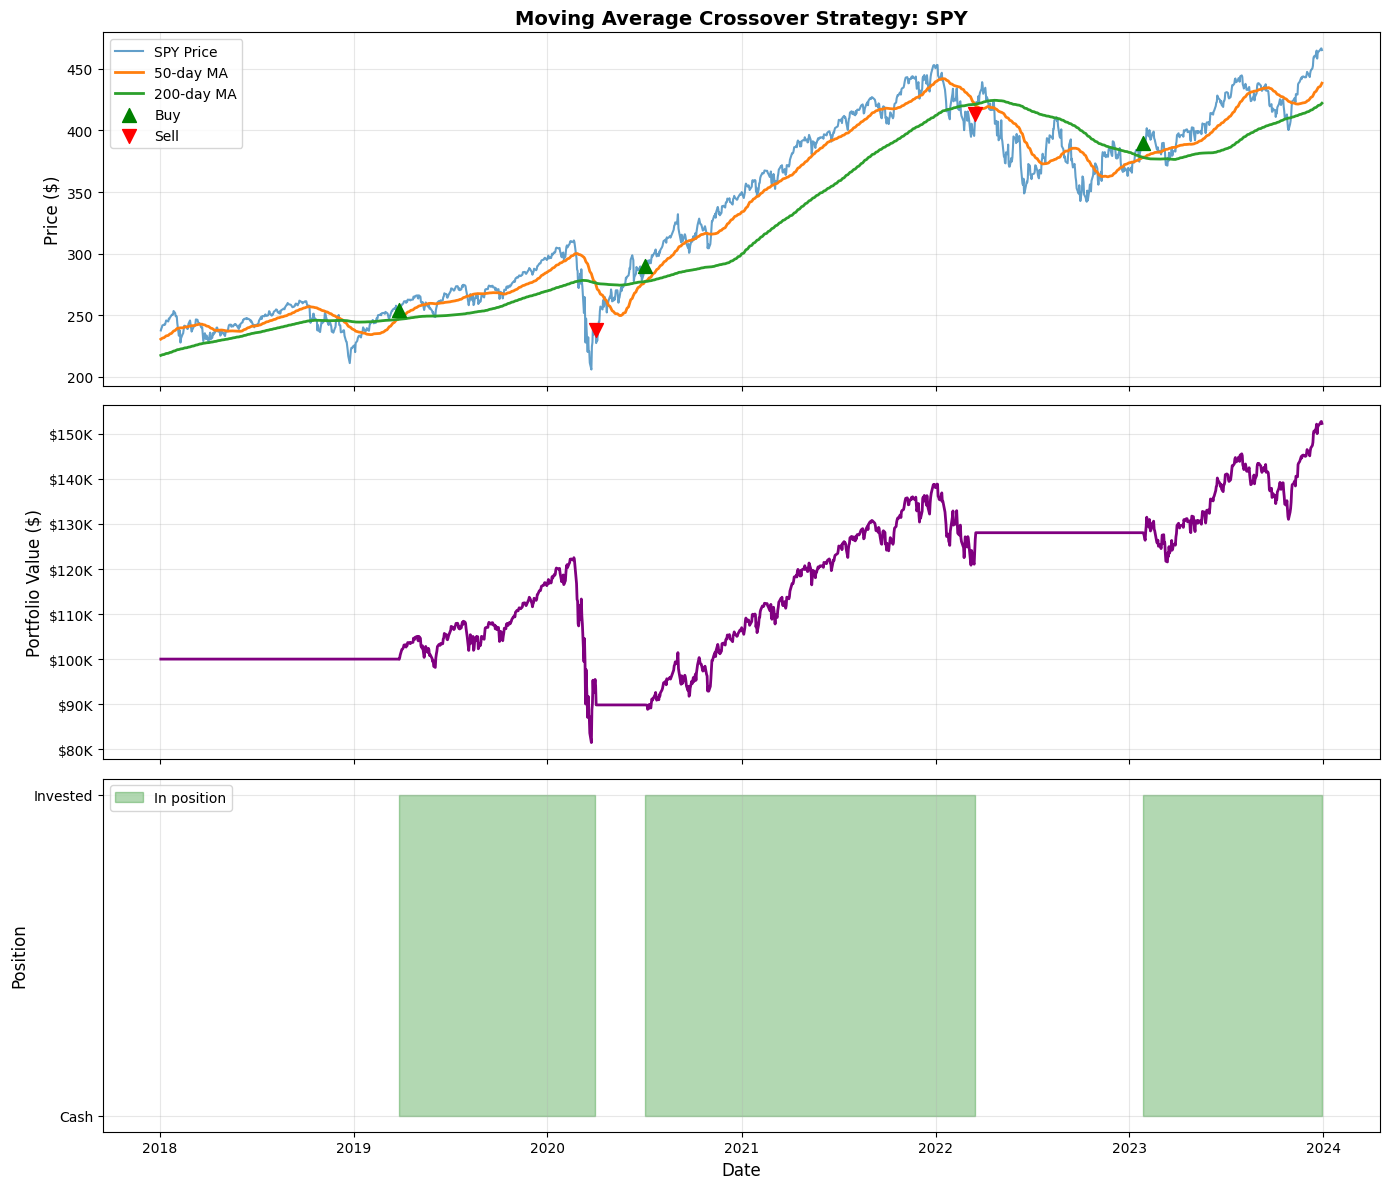

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: Price with MAs
axes[0].plot(results.index, results['price'], label=f'{STOCK} Price', linewidth=1.5, alpha=0.7)
axes[0].plot(results.index, results['fast_ma'], label=f'{FAST_MA}-day MA', linewidth=2)
axes[0].plot(results.index, results['slow_ma'], label=f'{SLOW_MA}-day MA', linewidth=2)

# Mark buy/sell signals
buy_signals = results[results['invested'].diff() == 1]
sell_signals = results[results['invested'].diff() == -1]

if not buy_signals.empty:
    axes[0].scatter(buy_signals.index, buy_signals['price'], 
                   marker='^', color='green', s=100, label='Buy', zorder=5)
if not sell_signals.empty:
    axes[0].scatter(sell_signals.index, sell_signals['price'], 
                   marker='v', color='red', s=100, label='Sell', zorder=5)

axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].set_title(f'Moving Average Crossover Strategy: {STOCK}', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: Portfolio value
axes[1].plot(results.index, results['portfolio_value'], linewidth=2, color='purple')
axes[1].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1].grid(True, alpha=0.3)

# Plot 3: Position indicator
axes[2].fill_between(results.index, 0, results['invested'], 
                     where=results['invested']==1, 
                     color='green', alpha=0.3, label='In position')
axes[2].set_ylabel('Position', fontsize=12)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['Cash', 'Invested'])
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Performance Metrics

In [7]:
# Calculate performance metrics
total_return = ((results['portfolio_value'].iloc[-1] / results['portfolio_value'].iloc[0]) - 1) * 100
daily_returns = results['portfolio_value'].pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)  # Annualized
max_drawdown = ((results['portfolio_value'] / results['portfolio_value'].cummax()) - 1).min() * 100

# Count trades
n_buys = len(results[results['invested'].diff() == 1])
n_sells = len(results[results['invested'].diff() == -1])

print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
print(f"Total Return: {total_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")
print(f"")
print(f"Final Portfolio Value: ${results['portfolio_value'].iloc[-1]:,.2f}")
print(f"Number of Buy Signals: {n_buys}")
print(f"Number of Sell Signals: {n_sells}")
print(f"Total Trades: {n_buys + n_sells}")
print("="*60)


PERFORMANCE SUMMARY
Total Return: 52.31%
Sharpe Ratio: 0.53
Max Drawdown: -33.51%

Final Portfolio Value: $152,310.52
Number of Buy Signals: 3
Number of Sell Signals: 2
Total Trades: 5


## Trade Log

In [8]:
# Extract all trades
trades = []
for date, row in results.iterrows():
    if len(row['transactions']) > 0:
        for txn in row['transactions']:
            trades.append({
                'Date': date.date(),
                'Action': 'BUY' if txn['amount'] > 0 else 'SELL',
                'Shares': abs(txn['amount']),
                'Price': txn['price'],
                'Value': abs(txn['amount'] * txn['price']),
                'Portfolio Value': row['portfolio_value']
            })

if trades:
    trades_df = pd.DataFrame(trades)
    print("\nAll Trades:")
    print(trades_df.to_string(index=False))
else:
    print("\nNo trades executed.")


All Trades:
      Date Action  Shares      Price         Value  Portfolio Value
2019-03-27    BUY     392 253.320597  99301.674024     99949.981976
2020-04-01   SELL     392 227.364261  89126.790312     89824.332288
2020-07-06    BUY     309 294.443148  90982.932732     89778.554556
2022-03-17   SELL     309 418.177806 129216.942208    128057.723764
2023-01-27    BUY     328 391.272538 128337.392628    127993.259136


## Next Steps

**Experiment with parameters:**
- Try different MA periods (e.g., 20/50, 10/30)
- Test on different stocks
- Add stop-loss or take-profit rules
- Combine with other indicators (RSI, MACD)

**Further analysis:**
- See `04_pyfolio_analysis.ipynb` for detailed risk/return metrics
- Compare with buy-and-hold strategy
- Test on different time periods